In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %load_ext dotenv
# %dotenv
# %dotenv /home/ml/Syncthing/Mac_Sync/ML_python/.env

# %load_ext autoreload
# %autoreload 2

# # To reload it, use:
# #   %reload_ext dotenv

# from importlib import reload
# import sys, os
# HOME = os.environ['HOME']
# sys.path.append(HOME+'/Syncthing/Mac_Sync/ML_python/')
# from py_imports import *
# from py_functions import *

# plt.style.use(["ml"])
# prop_cycle = [i['color'] for i in mpl.rcParams['axes.prop_cycle']]

# dpi = 70
# plt.rcParams['figure.dpi'] = dpi
# plt.gcf().set_dpi(dpi)


In [2]:
import pandas as pd
import networkx as nx


In [25]:
author_info_df = pd.read_csv('author_info_df.csv', index_col=0)
author_info_df.head()

name  n_papers  citationcount  \
48234930          M. Osborne         1             35   
2418685              A. Roth        49          12830   
2616074           B. Abraham         8            375   
3013323          J. Ledolter        11            815   
2108328585  Atiquzzafar Khan         2             52   

            influentialcitationcount  
48234930                           0  
2418685                          573  
2616074                           20  
3013323                           26  
2108328585                         2

In [26]:
edges_df0 = pd.read_csv('network_edges_df.csv', index_col=0)
edges_df0.head()

source      target  cites  year  n_papers_authors  \
0     2616074     3013323     68  17.0               9.5   
1     2177757    66698587     68  34.0              16.5   
2    50490130  2103677752     92  47.0               1.5   
3    50490130    46531631     92  47.0               2.0   
4  2103677752    46531631     92  47.0               1.5   

   citationcount_authors  influentialcitationcount_authors  
0                  595.0                              23.0  
1                  609.5                              47.0  
2                   99.5                               2.0  
3                  107.0                               2.0  
4                   99.5                               2.0

In [24]:
edges_df = edges_df0[['source', 'target']]
edges_df['weight'] = edges_df0['cites']
edges_df.head()

# edges_df['weight'] = np.log(edges_df.weight)

/tmp/ipykernel_383942/1096115518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df['weight'] = edges_df0['cites']


source      target  weight
0     2616074     3013323      68
1     2177757    66698587      68
2    50490130  2103677752      92
3    50490130    46531631      92
4  2103677752    46531631      92

In [6]:
G = nx.from_pandas_edgelist(edges_df, edge_attr=True)

len(G.nodes), len(G.edges)

(114508, 248885)

## Similarity measures by scholar
- Panther similarity: based on the idea that two nodes are considered similar if they frequently appear on the same paths within the network
- SimRank similarity: based on the principle that "two nodes are similar if they are connected to similar nodes"
- by overlap of descendants 

In [21]:
lastname = 'Lettau'
initial = 'M'

# lastname = 'Berk'
# initial = 'J'

# lastname = 'Campbell'
# initial = 'J'

a = author_info_df[author_info_df['name'].str.contains(lastname+'$') & author_info_df['name'].str.contains('^'+initial)]
print(a)

id = a.index[0]
for i in a.index:
    # i, len(df[df['author_ids'].apply(lambda x: authorid_in_coauthors(x, i))][cols1])
    try:
        len(G[i])
        G = nx.contracted_nodes(G, id, i)
    except:
        print(i, 'is not in network')
print('\n\n', id, a.loc[id,'name'], len(G[id]))

               name  n_papers  citationcount  influentialcitationcount
48082129  M. Lettau        42          12630                      1182
10263639  M. Lettau         3            174                        14
10263639 is not in network


 48082129 M. Lettau 24


In [26]:
len(G.nodes), len(G.edges)

(114507, 248885)

In [27]:
degrees = G.degree()

degrees = pd.DataFrame(degrees)
len(degrees)

degrees.sort_values(1, ascending=0).head()
authors_df[degrees.sort_values(1, ascending=0).head(10)[0]]



114507

0    1
701   1819574   204
5776  3345989   171
2684  3096029   168
9912  46242118  166
9012  2401462   161

1819574      Mike W. Peng       
3345989      B. Ratchford       
3096029      S. Sethi           
46242118     Vikram Nanda       
2401462      E. Haruvy          
3073122      Gary E. Bolton     
144055851    Ashiq Ali          
40079914     Upender Subramanian
50880028     M. Wright          
144533805    S. Radhakrishnan   
dtype: object

In [40]:
min_coauthors = 3
for i in degrees[degrees[1]<min_coauthors][0]:
    G.remove_node(i)

len(G.nodes), len(G.edges)

(52436, 175091)

In [41]:
for i in author_info_df[author_info_df.citationcount<100].index:
    try:
        G.remove_node(i)
    except:
        None

len(G.nodes), len(G.edges)

(44104, 140393)

In [50]:
def network_graph(id, level=1):
    l_sub = []
    for i in range(level+1):
        l_sub = l_sub + list(nx.descendants_at_distance(G, id, i))
    G_sub = nx.subgraph(G, l_sub)
    
    scholar_coauthors = list(nx.descendants_at_distance(G, id, 1))
    labels = authors_df[list(G_sub.nodes)].to_dict()
    # labels
    
    # layout = nx.drawing.spring_layout(G_sub, weight='weight')
    layout = nx.drawing.arf_layout(G_sub, a=10)
    node_intensities = nx.eigenvector_centrality(G, weight=None)
    # node_intensities = {i: (node_intensities[i]) for i in G_sub.nodes}
    # edge_intensities = [1+np.log(i[2]) for i in G_sub.edges.data("weight")]
    
    _=plt.figure(figsize=(25,15))
    _=nx.draw_networkx(G_sub, 
                       labels=labels,
                       pos=layout, 
                       node_size=10, 
                       font_size=12, 
                       # font_weight='semibold', 
                       edge_color='orange',
                       # node_color=list((intensities.values())), cmap='gist_heat_r', alpha=.5,
                       # width=edge_intensities)
                      )
    plt.tight_layout()
    plt.show()

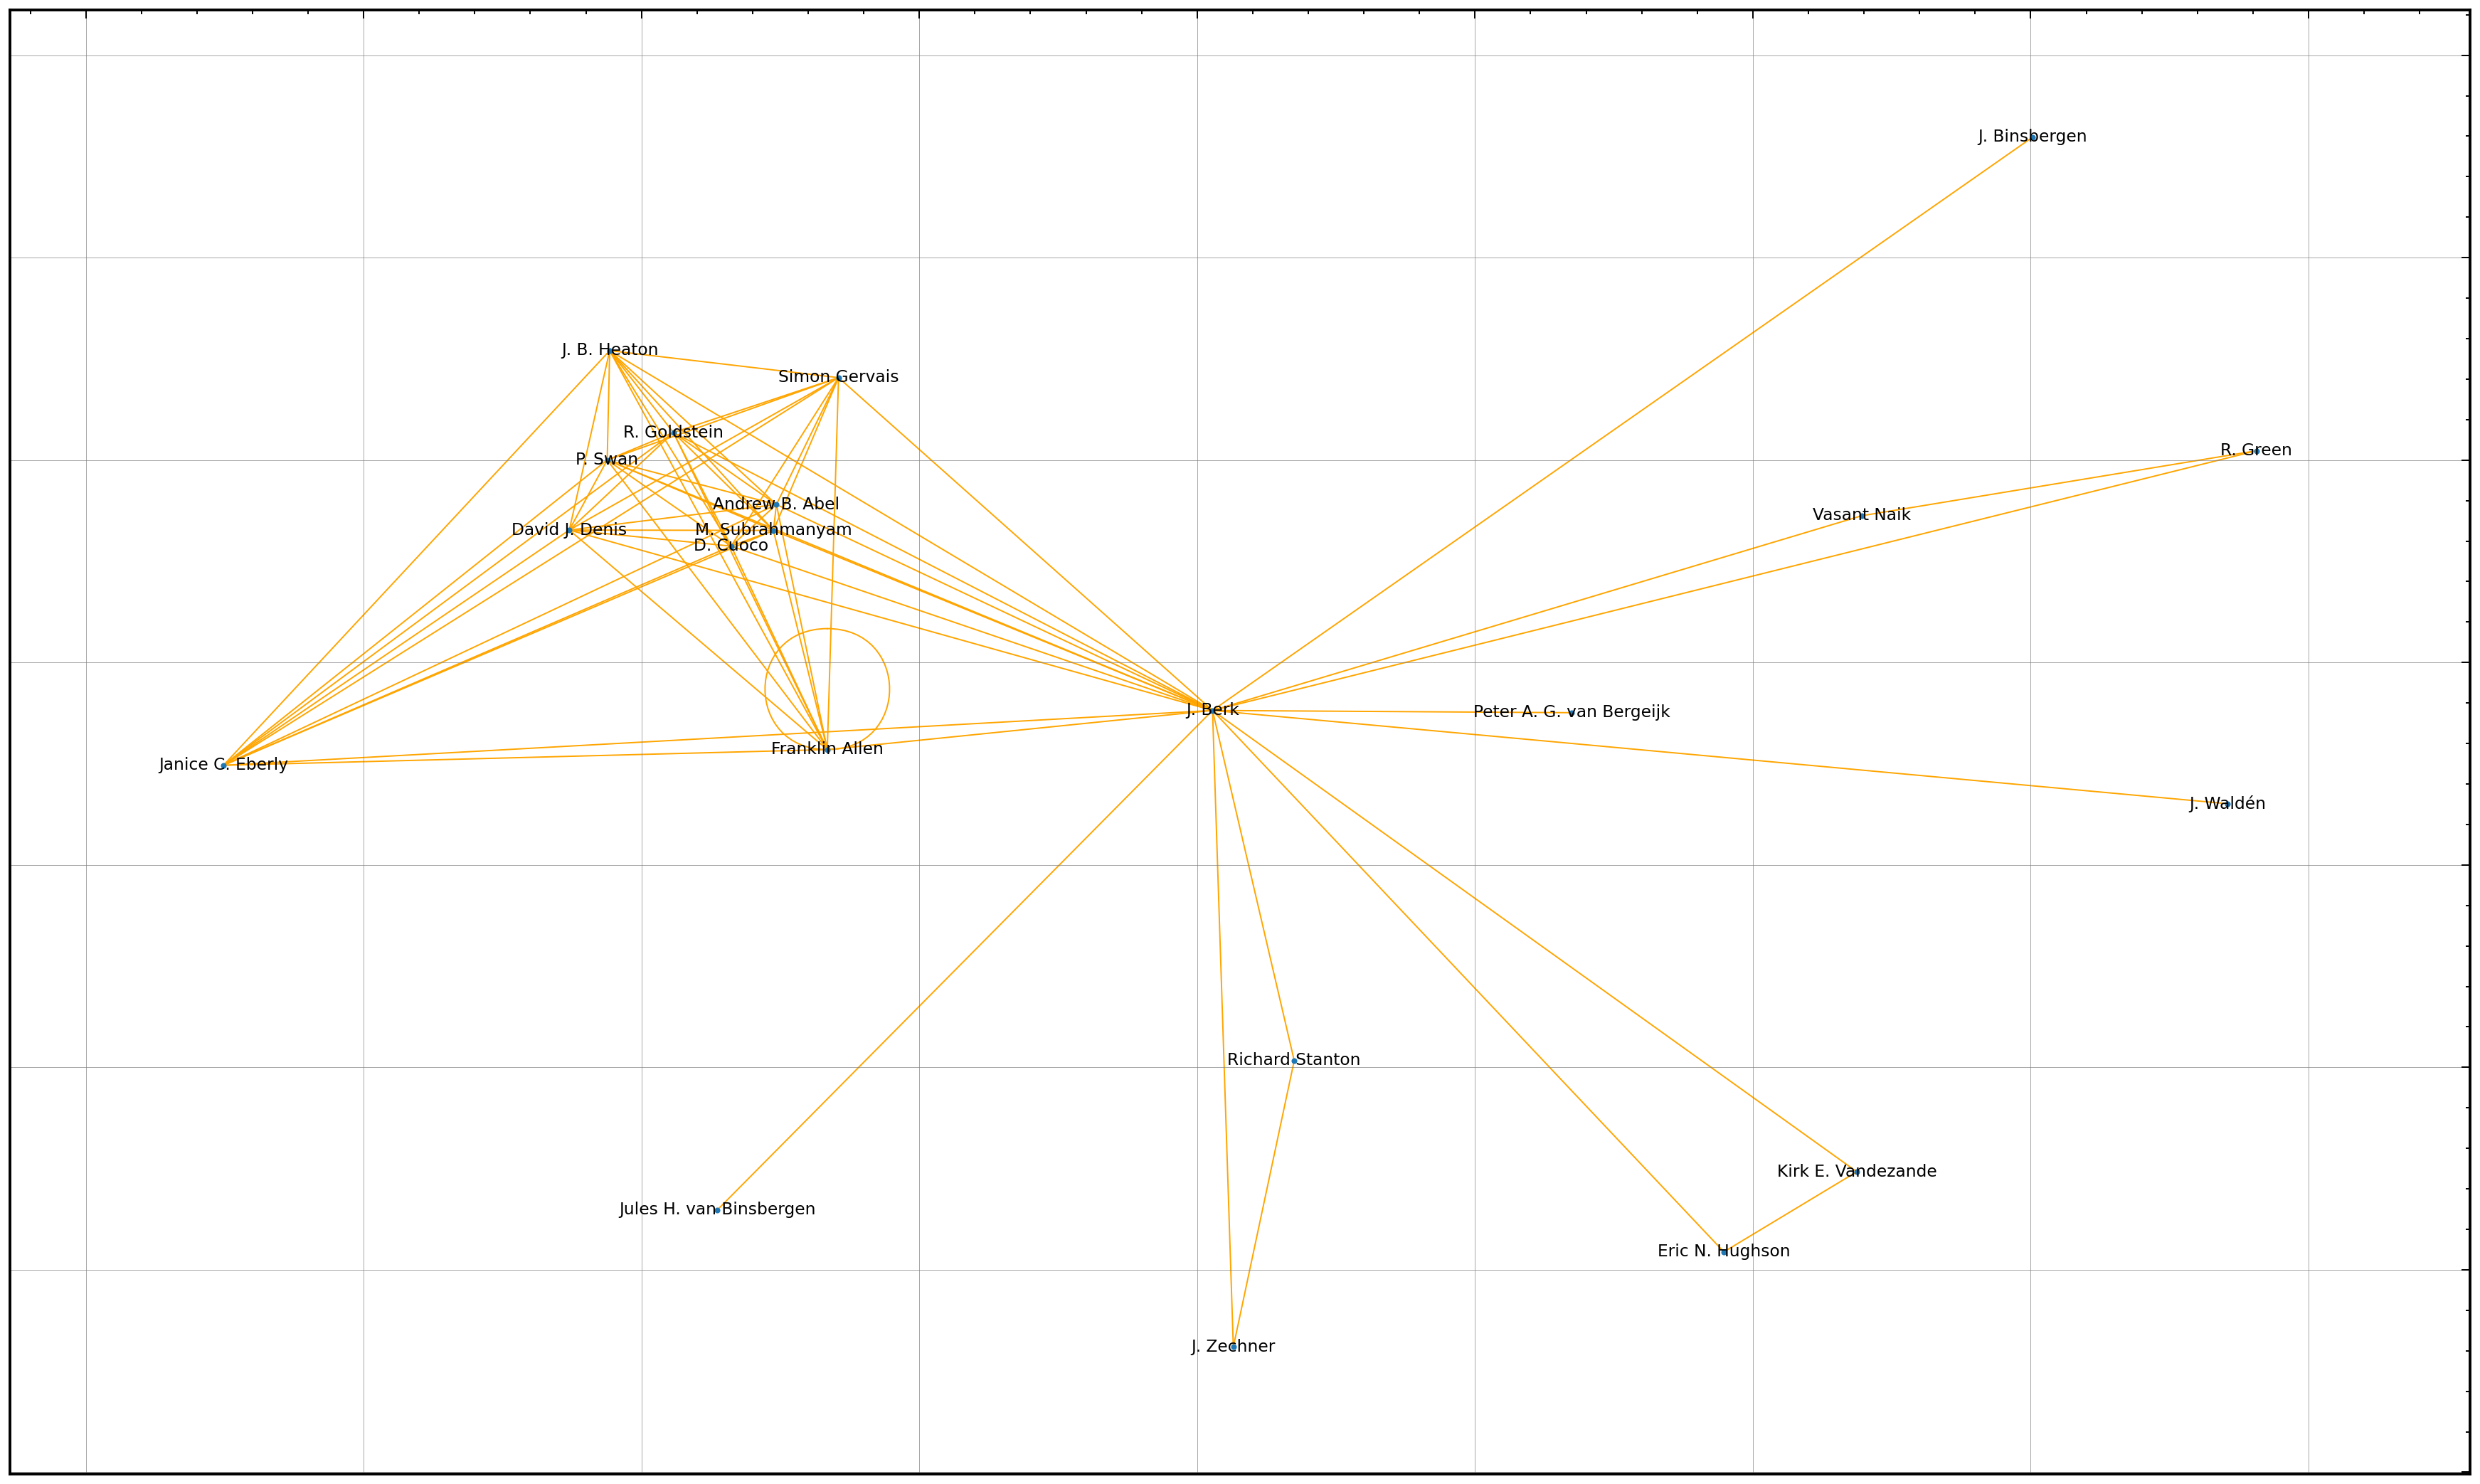

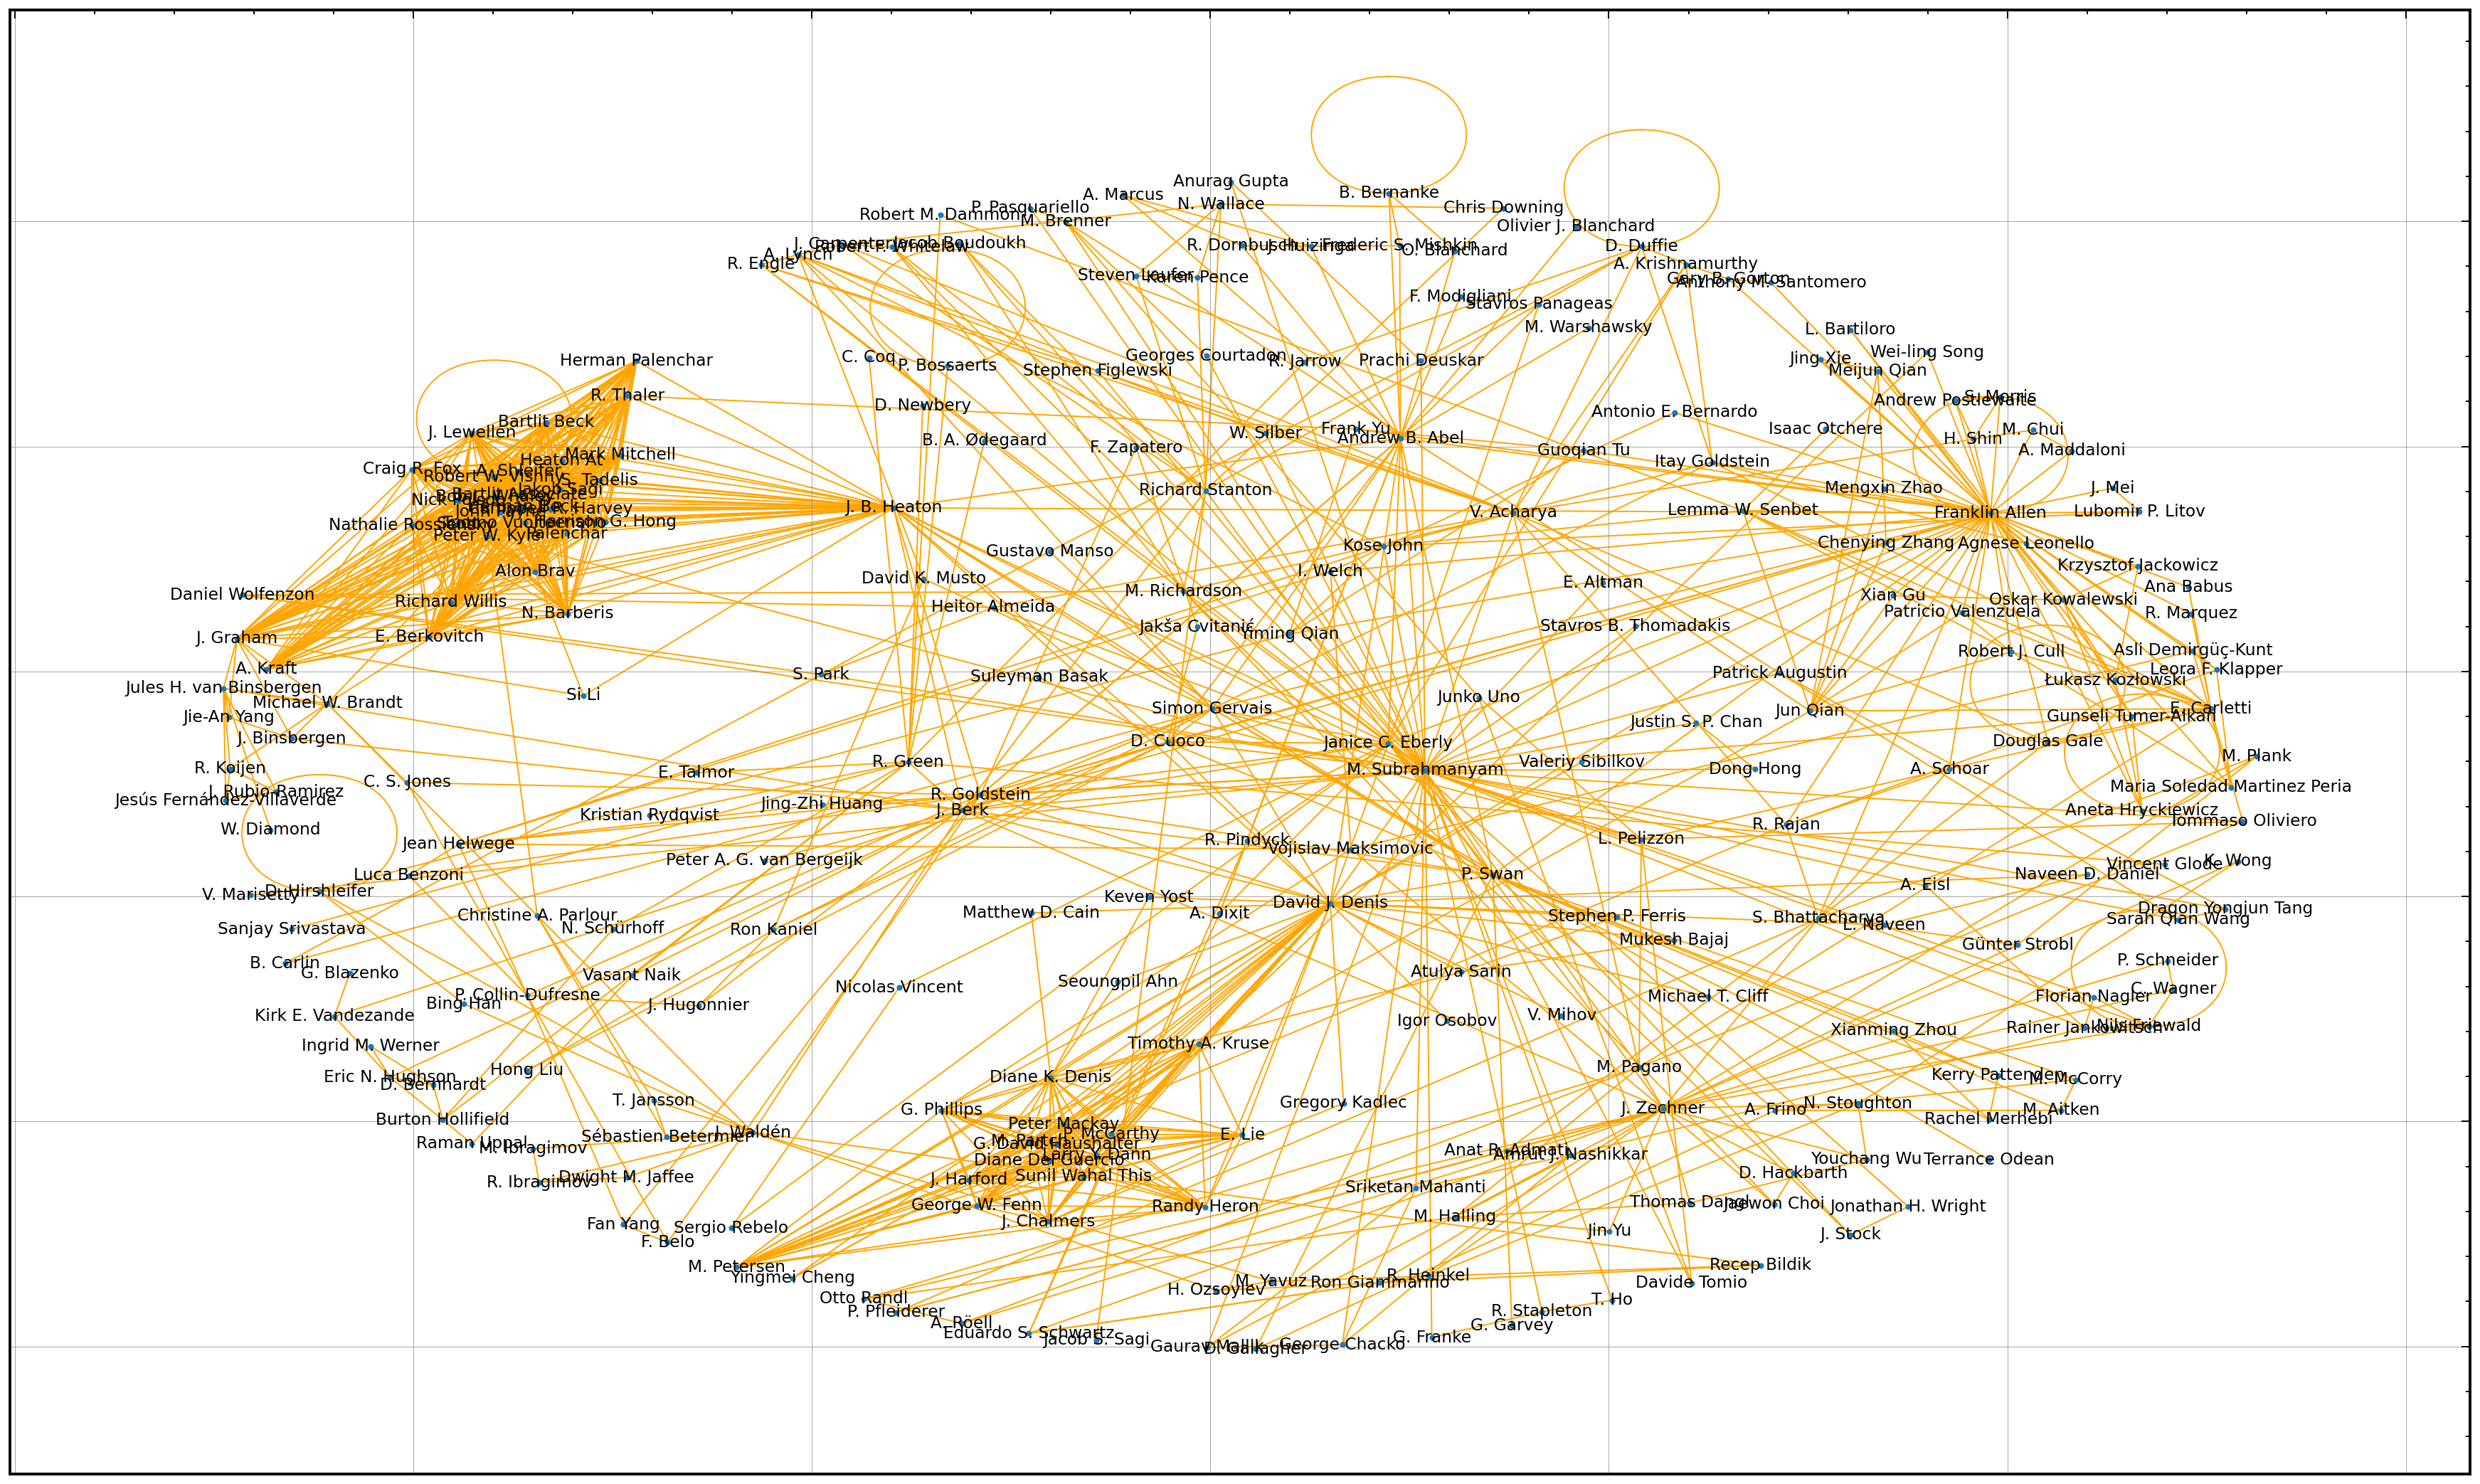

In [52]:
network_graph(id, level=1)
network_graph(id, level=2)

In [254]:
similarity_scholar = pd.DataFrame()

In [ ]:
### Panther similarity: based on the idea that two nodes are considered similar if they frequently appear on the same paths within the network

### non-weighted

x = pd.DataFrame()
for i in tqdm(list(range(5))[:1]):
    
    # weight = 'weight'
    weight = None
    path_length = 3
    
    x[i] = panther_sim = pd.Series(nx.panther_similarity(G, id, k=50, path_length=path_length, weight=weight, eps=1/len(G.edges)**.5))
panther_similarity = 10000*x.replace(np.nan,0).mean(axis=1).squeeze()
similarity_scholar['panther'] = (panther_similarity)
panther_similarity = pd.concat([authors_df[panther_similarity.index], panther_similarity], axis=1)
panther_similarity.columns = ['scholar', 'score']

panther_similarity.sort_values('score', ascending=0).head(25)
panther_similarity.sort_values('score', ascending=0).drop(scholar_coauthors, errors='ignore').head(10)

  0%|                                                                                     | 0/1 [00:00<?, ?it/s]

In [151]:
### Panther similarity: based on the idea that two nodes are considered similar if they frequently appear on the same paths within the network

### weighted

x = pd.DataFrame()
for i in tqdm(list(range(5))[:1]):
    
    weight = 'weight'
    # weight = None
    path_length = 3
    
    x[i] = panther_sim = pd.Series(nx.panther_similarity(G, id, k=50, path_length=path_length, weight=weight, eps=1/len(G.edges)**.5))
panther_similarity_w = 10000*x.replace(np.nan,0).mean(axis=1).squeeze()
similarity_scholar['panther_w'] = (panther_similarity_w)
panther_similarity_w = pd.concat([authors_df[panther_similarity_w.index], panther_similarity_w], axis=1)
panther_similarity_w.columns = ['scholar', 'score']

panther_similarity_w.sort_values('score', ascending=0).head(25)
panther_similarity_w.sort_values('score', ascending=0).drop(scholar_coauthors, errors='ignore').head(10)

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.43s/it]


scholar  score
6922422     J. Zechner                   1.82  
145360727   Richard Stanton              1.82  
119176082   Janice C. Eberly             0.83  
50115523    R. Goldstein                 0.76  
2592335     D. Cuoco                     0.68  
1747992     Franklin Allen               0.61  
2477807     M. Subrahmanyam              0.61  
69433375    J. B. Heaton                 0.53  
49230897    David J. Denis               0.53  
2992937     Simon Gervais                0.38  
48325867    Andrew B. Abel               0.30  
46257100    P. Swan                      0.23  
40458456    M. Pagano                    0.23  
48752808    Ron Kaniel                   0.15  
40296843    I. Welch                     0.15  
36018540    A. Dixit                     0.15  
94220167    M. Richardson                0.15  
118833599   Diane Del Guercio            0.15  
119378403   Ron Giammarino               0.15  
1398328959  Asli Demirgüç-Kunt           0.15  
3436008     R. Pindyck                   0.08  
1399041937  P. Collin-Dufresne           0.08  
90297793    Beverly R. Walther           0.08  
152198301   Robert F. Whitelaw           0.08  
1741091854  Maria Soledad Martinez Peria 0.08

scholar  score
40458456    M. Pagano          0.23  
48752808    Ron Kaniel         0.15  
40296843    I. Welch           0.15  
36018540    A. Dixit           0.15  
94220167    M. Richardson      0.15  
118833599   Diane Del Guercio  0.15  
119378403   Ron Giammarino     0.15  
1398328959  Asli Demirgüç-Kunt 0.15  
3436008     R. Pindyck         0.08  
1399041937  P. Collin-Dufresne 0.08

In [152]:
### SimRank similarity: based on the principle that "two nodes are similar if they are connected to similar nodes"
### Note: questionable results

simrank_similarity = pd.Series(nx.simrank_similarity(G, id,
                                                    # importance_factor=0.9, max_iterations=1000, tolerance=0.0001
                                                    importance_factor=1, max_iterations=500, tolerance=0.0095
                                                    # importance_factor=1.2, max_iterations=50, tolerance=0.01
                                                    ))
simrank_similarity = standard(simrank_similarity.drop(id)).squeeze()
similarity_scholar['simrank'] = (simrank_similarity)

simrank_similarity = pd.concat([authors_df[simrank_similarity.index], simrank_similarity], axis=1)
simrank_similarity.columns = ['scholar', 'score']
simrank_similarity.sort_values('score', ascending=0).head(20)
simrank_similarity.sort_values('score', ascending=0).drop(scholar_coauthors, errors='ignore').head(10)

scholar  score
145360727   Richard Stanton     17.87 
6922422     J. Zechner          16.34 
2592335     D. Cuoco            10.27 
48325867    Andrew B. Abel      9.23  
36018540    A. Dixit            8.94  
119176082   Janice C. Eberly    8.76  
50115523    R. Goldstein        8.50  
3323460     Eduardo S. Schwartz 8.42  
3436008     R. Pindyck          8.37  
46257100    P. Swan             8.12  
104190127   Jacob Boudoukh      7.00  
2992937     Simon Gervais       6.95  
119173619   A. Frino            6.47  
2477807     M. Subrahmanyam     5.98  
39861967    M. Aitken           5.71  
119378403   Ron Giammarino      5.41  
49230897    David J. Denis      5.04  
118833599   Diane Del Guercio   4.82  
2227079665  G. David Haushalter 4.82  
2227081821  Randy Heron         4.82

scholar  score
36018540    A. Dixit            8.94  
3323460     Eduardo S. Schwartz 8.42  
3436008     R. Pindyck          8.37  
104190127   Jacob Boudoukh      7.00  
119173619   A. Frino            6.47  
39861967    M. Aitken           5.71  
119378403   Ron Giammarino      5.41  
118833599   Diane Del Guercio   4.82  
2227079665  G. David Haushalter 4.82  
2227081821  Randy Heron         4.82

In [163]:
similarity_scholar = standard(similarity_scholar.replace(np.nan, 0))
similarity_scholar['mean'] = similarity_scholar.mean(axis=1)
similarity_scholar['name'] = author_info_df.loc[similarity_scholar.index]['name']

similarity_scholar.sort_values('mean', ascending=0)

ValueError: could not convert string to float: 'J. Zechner'